# Intro to Federated Learning with Flower and Keras

Alex Kyllo 2022-10-29

In this notebook, we'll build a simulated federated learning system using Flower
and Keras.

In a production FL environment, you would have a central server communicating
with many clients on different machines (like smartphones) over the network, but
Flower provides a simulation framework so that you can run a whole FL environment
locally, even in a Jupyter notebook like this.

Let's get started! 🌻

## Part 0: Setup


### Installing dependencies

First, let's install Python packages we need to run the notebook:

In [1]:
!pip install flwr[simulation] tensorflow numpy matplotlib

Now that we have the necessary packages installed, we can import everything we need for this tutorial:

In [12]:
import os
from collections import OrderedDict
from typing import List, Tuple
# Silence TF warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
from flwr.common import Metrics
from flwr.server.strategy import FedAvg
from flwr.simulation import start_simulation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tensorflow", tf.__version__)

flwr 1.0.0
numpy 1.22.3
tensorflow 2.10.0


### Loading the data

In this tutorial, we'll introduce federated learning by training a simple neural
network on the MNIST handwritten digit recognition dataset, a well-known
computer vision benchmark. The task is to recognize images of the digits 0-9.

We simulate having multiple users by splitting the dataset into partitions. Each
partition will represent the data from a single user. We're doing this purely
for experimentation purposes, in the real world there's no need for data
splitting because each user already has their own data local to their device.
Each user's device is a client, so having ten clients participate in a
federation means having ten clients connected to the federated learning server.

In [31]:
# Set some config variables
NUM_CLIENTS = 5
NUM_CLASSES = 10
NUM_ROUNDS = 3
INPUT_SHAPE = (28, 28, 1)
BATCH_SIZE = 64
EPOCHS = 10

Let's load the MNIST training and test set and partition them into ten smaller datasets (each split into training and validation set).

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [5]:
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train_onehot = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_onehot = keras.utils.to_categorical(y_test, NUM_CLASSES)
# split data for clients
x_train_splits = np.array_split(x_train, NUM_CLIENTS)
y_train_splits = np.array_split(y_train_onehot, NUM_CLIENTS)
x_test_splits = np.array_split(x_test, NUM_CLIENTS)
y_test_splits = np.array_split(y_test_onehot, NUM_CLIENTS)
data_splits = [((x, y), (xt, yt)) for (x, y, xt, yt) in zip(x_train_splits, y_train_splits, x_test_splits, y_test_splits)]


Then let's plot a sample of the MNIST digits just to visualize the data we're
using for the ML task.

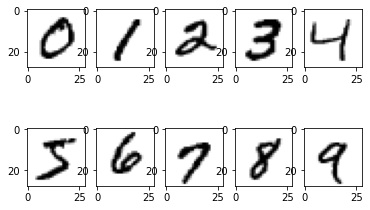

In [6]:
fig, ax = plt.subplots(2,5)
for i, ax in enumerate(ax.flatten()):
    im_idx = np.argwhere(y_train == i)[0,0]
    plottable_image = np.reshape(x_train[im_idx], (28, 28))
    ax.imshow(plottable_image, cmap='gray_r')

## Part 1: Centralized Training



Next, we're going to define a simple model and train it locally on one of the
ten client splits.


### Defining the model


In [29]:
def build_model():
    model = keras.Sequential(
        [
            keras.Input(shape=INPUT_SHAPE),
            # Comment out the two Dense layers
            # and uncomment the Conv2D and MaxPooling layers layers if you want a CNN
            layers.Dense(8, activation="relu"),
            layers.Dense(4, activation="relu"),
            # layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            # layers.MaxPooling2D(pool_size=(2, 2)),
            # layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            # layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            # layers.Dropout(0.5),
            layers.Dense(NUM_CLASSES, activation="softmax"),
        ]
    )
    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0005), metrics=["accuracy"])
    return model


model = build_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 28, 28, 8)         16        
                                                                 
 dense_28 (Dense)            (None, 28, 28, 4)         36        
                                                                 
 flatten_9 (Flatten)         (None, 3136)              0         
                                                                 
 dense_29 (Dense)            (None, 10)                31370     
                                                                 
Total params: 31,422
Trainable params: 31,422
Non-trainable params: 0
_________________________________________________________________


In [30]:
(x_train_0, y_train_0), (x_test_0, y_test_0) = data_splits[0]
model.fit(x_train_0, y_train_0, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1)

Epoch 1/20
169/169 [==============================] - 2s 8ms/step - loss: 1.0859 - accuracy: 0.7510 - val_loss: 0.5487 - val_accuracy: 0.8708
Epoch 2/20
169/169 [==============================] - 1s 7ms/step - loss: 0.4463 - accuracy: 0.8836 - val_loss: 0.3926 - val_accuracy: 0.9008
Epoch 3/20
169/169 [==============================] - 1s 8ms/step - loss: 0.3507 - accuracy: 0.9035 - val_loss: 0.3458 - val_accuracy: 0.9017
Epoch 4/20
169/169 [==============================] - 1s 7ms/step - loss: 0.3107 - accuracy: 0.9132 - val_loss: 0.3239 - val_accuracy: 0.9067
Epoch 5/20
169/169 [==============================] - 1s 7ms/step - loss: 0.2839 - accuracy: 0.9209 - val_loss: 0.3155 - val_accuracy: 0.9150
Epoch 6/20
169/169 [==============================] - 1s 8ms/step - loss: 0.2678 - accuracy: 0.9262 - val_loss: 0.3043 - val_accuracy: 0.9117
Epoch 7/20
169/169 [==============================] - 1s 8ms/step - loss: 0.2522 - accuracy: 0.9296 - val_loss: 0.3021 - val_accuracy: 0.9150
Epoch 

Now that we've covered the local model fitting process, let's take a look at how
this would work in federated learning!

## Part 2: Federated Learning with Flower

Part 1 demonstrated a simple centralized training pipeline. Next, we'll simulate
a situation where we have multiple datasets across multiple devices and where we
train a model over these devices using federated learning.

### Updating model parameters

In federated learning, the server sends the global model parameters to the client, and the client updates the local model with the parameters received from the server. It then trains the model on the local data (which changes the model parameters locally) and sends the updated/changed model parameters back to the server (or, alternatively, it sends just the gradients back to the server, not the full model parameters).


### Implementing a Flower client

With that out of the way, let's move on to the interesting part. Federated learning systems consist of a server and multiple clients. In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Return the current local model parameters
* `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
* `evaluate`: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

Let's see a simple Flower client implementation that brings everything together:

In [9]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, cid, train_data, test_data, epochs, batch_size):
        self.model = model
        self.cid = int(cid)
        self.x_train, self.y_train = train_data
        self.x_test, self.y_test = test_data
        self.epochs = epochs
        self.batch_size = batch_size

    def get_parameters(self, config):
        return self.model.get_weights()
    
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.x_test, self.y_test)
        return loss, len(self.x_test), {"accuracy": float(accuracy)}

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise there's not much to federate), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, then we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

### Using the Virtual Client Engine

In this notebook, we want to simulate a federated learning system with 10 clients on a single machine. This means that the server and all 10 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 10 clients would mean having 10 instances of `FlowerClient` im memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower therefore provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use, so they should not keep any local state). Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for different clients, as can be seen below:

In [10]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    print(f"cid: {cid}")
    # Load data (MNIST) and
    (x_train, y_train), (x_test, y_test) = data_splits[int(cid)]
    # Create a single Flower client representing a single device
    return FlowerClient(build_model(), cid, (x_train, y_train), (x_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)

### Aggregate metrics

Flower can automatically aggregate losses returned by individual clients, but it cannot do the same for metrics in the generic metrics dictionary (the one with the `accuracy` key). Metrics dictionaries can contain very different kinds of metrics and even key/value pairs that are not metrics at all, so the framework does not (and can not) know how to handle these automatically.

As users, we need to tell the framework how to handle/aggregate these custom metrics, and we do so by passing metric aggregation functions to the strategy. The strategy will then call these functions whenever it receives fit or evaluate metrics from clients. The two possible functions are `fit_metrics_aggregation_fn` and `evaluate_metrics_aggregation_fn`.

Let's create a simple weighted averaging function to aggregate the `accuracy` metric we return from `evaluate`:

In [11]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    
    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

### Starting the training

We now have the class `FlowerClient` which defines client-side training/evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client. The last step is to start the actual simulation using `flwr.simulation.start_simulation`. 

The function `start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate (`num_clients`), the number of federated learning rounds (`num_rounds`), and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg).

Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters. The last step is the actual call to `start_simulation` which - you guessed it - starts the simulation:

In [ ]:
# Create FedAvg strategy
strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
history = start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)

### Behind the scenes

So how does this work? How does Flower execute this simulation?

When we call `start_simulation`, we tell Flower that there are 10 clients (`num_clients=10`). Flower then goes ahead an asks the `FedAvg` strategy to select clients. `FedAvg` knows that it should select 100% of the available clients (`fraction_fit=1.0`), so it goes ahead and selects 10 random clients (i.e., 100% of 10).

Flower then asks the selected 10 clients to train the model. When the server receives the model parameter updates from the clients, it hands those updates over to the strategy (*FedAvg*) for aggregation. The strategy aggregates those updates and returns the new global model, which then gets used in the next round of federated learning.

We now have a full system that performs federated training and federated evaluation. It uses the `weighted_average` function to aggregate custom evaluation metrics and calculates a single `accuracy` metric across all clients on the server side.

The other two categories of metrics (`losses_centralized` and `metrics_centralized`) are still empty because they only apply when centralized evaluation is being used.

## Final remarks

Congratulations, you just trained a neural network, federated over 10 clients!
With that, you understand the basics of federated learning with Flower. The same
approach you've seen can be used with other machine learning frameworks like
PyTorch or TensorFlow, and can be run for real on distributed client devices.